In [1]:
!conda activate ctg

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional
import scipy.interpolate
import seaborn as sns
from scipy import stats
from scipy.stats import norm
from scipy.signal import find_peaks, peak_prominences, peak_widths 
from sklearn.linear_model import LinearRegression
import warnings
import pywt
#from tsfresh.feature_extraction import feature_calculators

from typing import Dict
warnings.simplefilter('ignore', np.RankWarning)
%matplotlib inline

In [3]:
sys.path.append('..')

In [4]:
from src.helpers.helpers import load_patient_data, time_span, plot_ctg, plot_fhr 
from src.helpers.preprocess import *

In [5]:
DATA_DIR = '../../data/database/database/signals'
META_FILE = '../meta.csv'
RESULTS_DIR = '../../output/pics'

In [6]:
df_train = pd.read_csv(META_FILE)
df_train = df_train.drop(['Unnamed: 0'], axis = 1)
patients = df_train['patient'].values
df_train.head()

,patient,pH,BDecf,pCO2,BE,Apgar1,Apgar5,Gest. weeks,Weight(g),Sex,...,Induced,I.stage,NoProgress,CK/KP,II.stage,Deliv. type,dbID,Rec. type,Pos. II.st.,target
0,1220,7.30,3.52,6.0,-4.7,9.0,10.0,42.0,3100.0,2.0,...,1.0,165.0,0.0,0.0,15.0,1.0,1051632.0,2.0,14400.0,0
1,1234,7.29,2.50,6.5,-4.2,8.0,9.0,41.0,3200.0,1.0,...,0.0,135.0,0.0,0.0,10.0,1.0,1054195.0,1.0,14400.0,0
2,1208,7.23,5.84,6.6,-7.4,9.0,9.0,40.0,3900.0,2.0,...,0.0,260.0,0.0,0.0,30.0,1.0,1049536.0,12.0,14400.0,0
3,1038,7.33,2.72,5.7,-4.0,10.0,10.0,39.0,2740.0,1.0,...,0.0,15.0,0.0,0.0,10.0,1.0,1002508.0,1.0,14400.0,0
4,1004,7.30,5.19,5.5,-6.4,8.0,9.0,41.0,3370.0,1.0,...,1.0,55.0,0.0,0.0,10.0,1.0,983277.0,12.0,14400.0,0


In [21]:
# normal
norm = df_train['patient'][df_train['pH'] >= 7.15].values
norm[:10]

array([1220, 1234, 1208, 1038, 1004, 1010, 1022, 2041, 1206, 1212],
      dtype=int64)

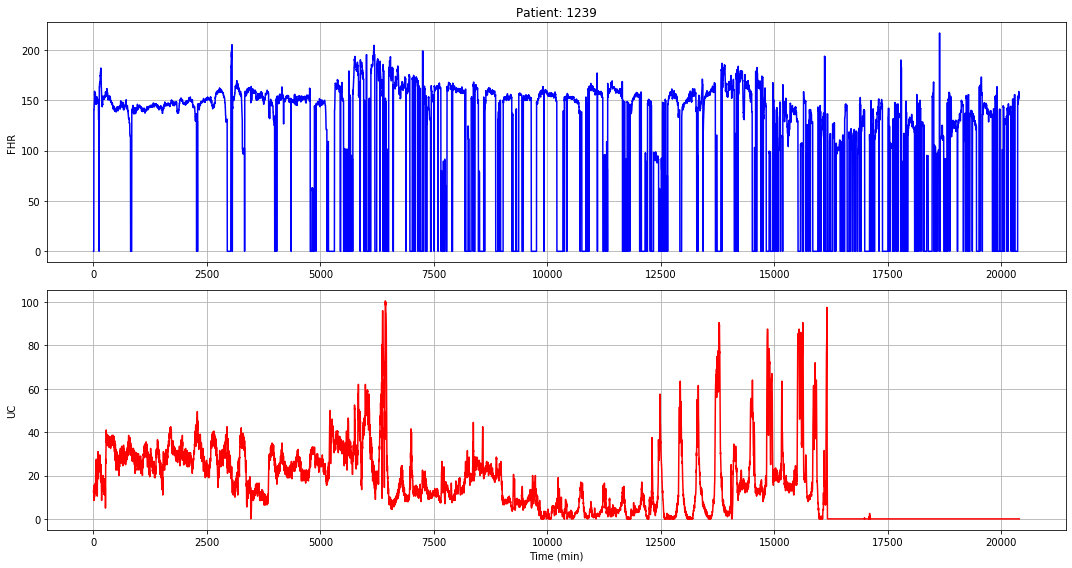

In [22]:
patient = patients[70]
fhr, uc, _ = load_patient_data(DATA_DIR, int(patient))
fig = plot_ctg(fhr, uc, patient_num = patient)   

(array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 140.5 ,
        140.5 , 140.75]),
 array([   nan,    nan,    nan,    nan,    nan,    nan,    nan, 140.5 ,
        140.5 , 140.75]),
 array([], dtype=float64))

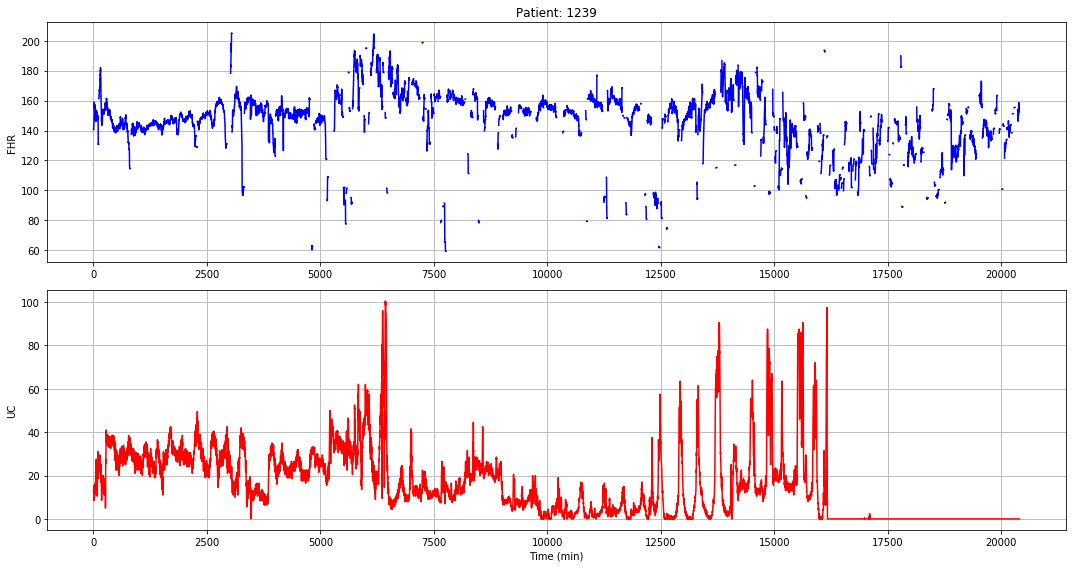

In [23]:
fhr2 = remove_artefacts(fhr)
fhrnan = zero_to_nan(fhr2)
fig = plot_ctg(fhrnan, uc, patient_num = patient) 
fhr2[:10], fhrnan[:10], fhr2[np.isnan(fhr2)]

(array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 140.5 ,
        140.5 , 140.75]),
 array([   nan,    nan,    nan,    nan,    nan,    nan,    nan, 140.5 ,
        140.5 , 140.75]),
 array([], dtype=float64))

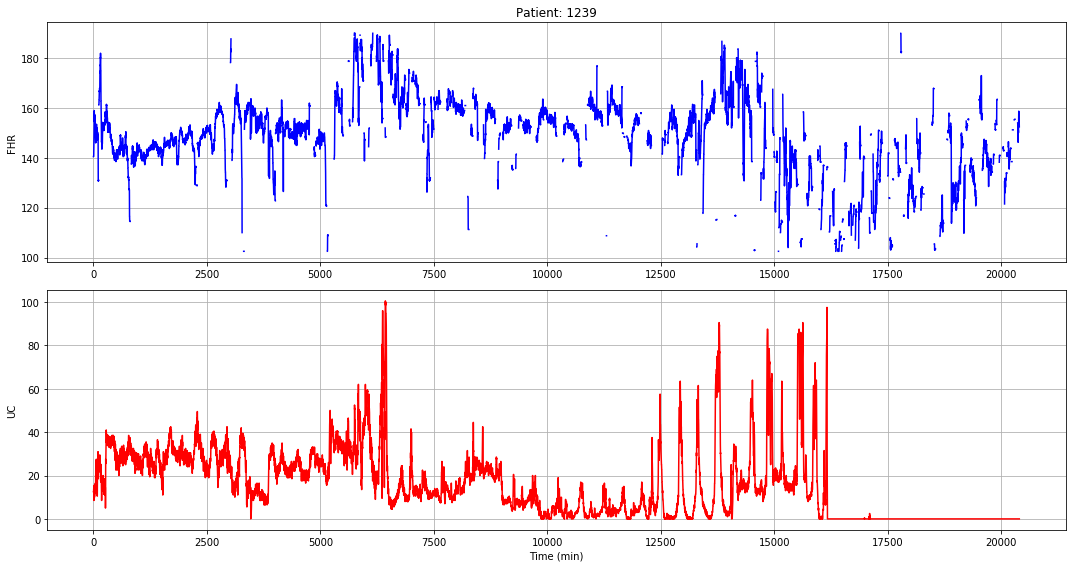

In [24]:
fhr3 = remove_global_outliers(fhr2)
fhrnan = zero_to_nan(fhr3)
fig = plot_ctg(fhrnan, uc, patient_num = patient) 
fhr3[:10], fhrnan[:10], fhr3[np.isnan(fhr3)]

(array([  0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  , 140.5 ,
        140.5 , 140.75]),
 array([   nan,    nan,    nan,    nan,    nan,    nan,    nan, 140.5 ,
        140.5 , 140.75]),
 array([], dtype=float64))

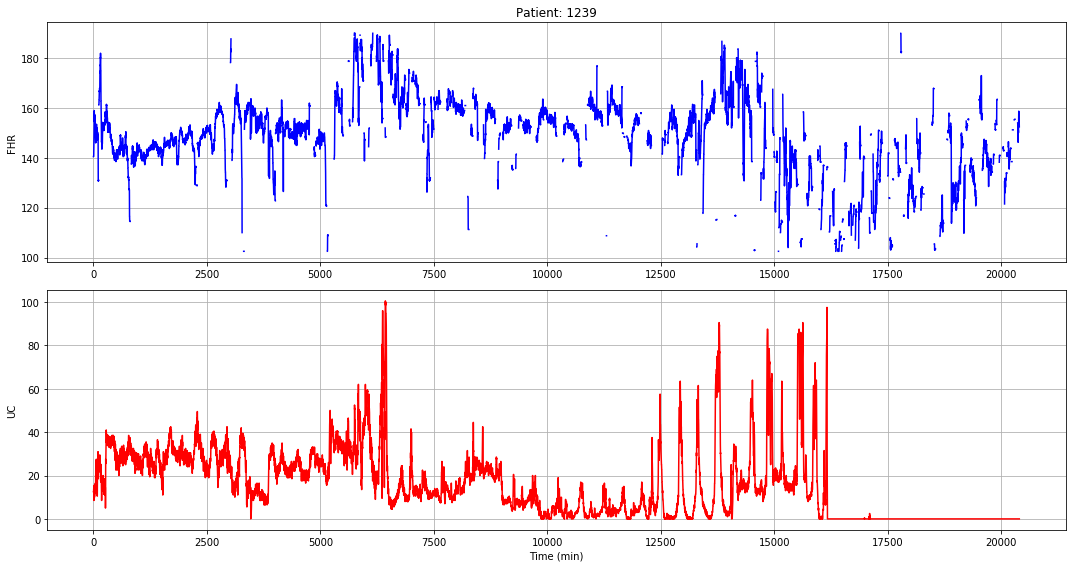

In [25]:
fhr4 = remove_local_outliers(fhr3, 5, 0.3)
fhrnan = zero_to_nan(fhr4)
fig = plot_ctg(fhrnan, uc, patient_num = patient) 
fhr4[:10], fhrnan[:10], fhr4[np.isnan(fhr4)]

In [26]:
time = np.arange(len(fhr))

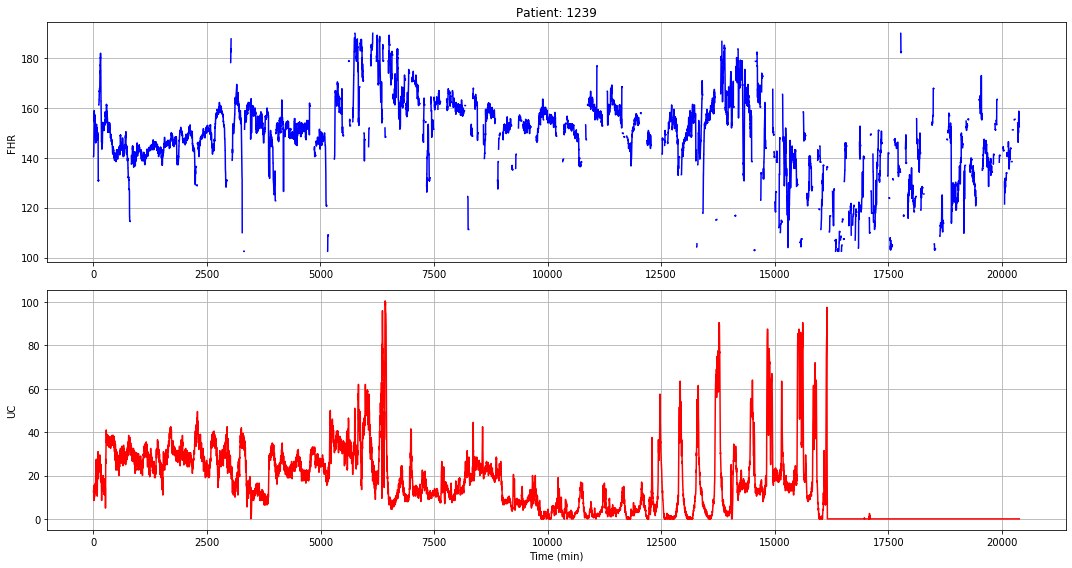

In [27]:
fhr5, uc5, time5 = remove_between_zeros_ctg(fhr4, uc, time, num=5)
fig = plot_ctg(zero_to_nan(fhr5), uc5, patient_num = patient) 

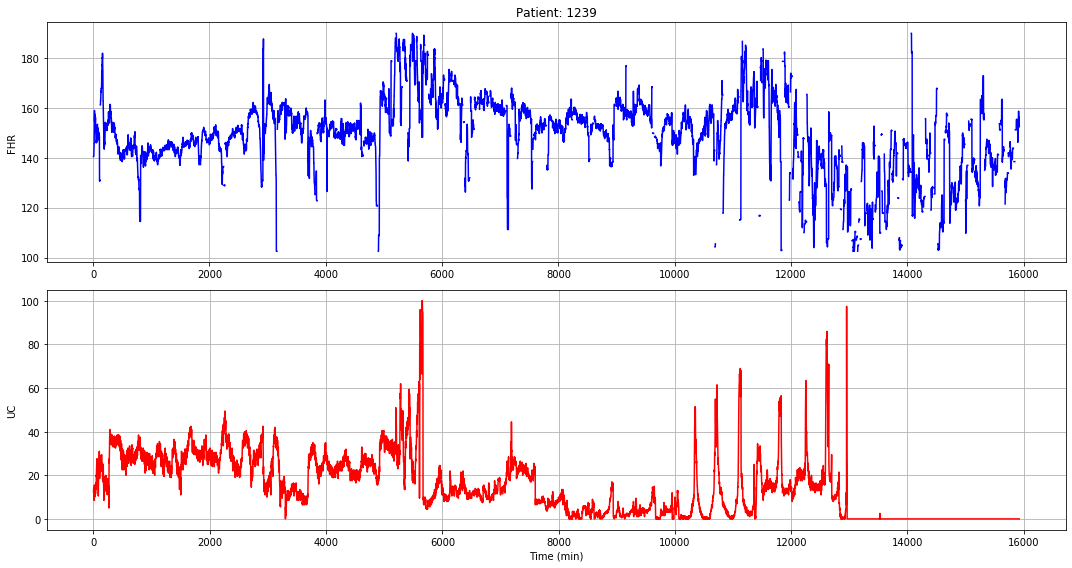

In [28]:
fhr6, uc6, time6 = remove_longzeros_ctg(fhr5, uc5, time5)
fig = plot_ctg(zero_to_nan(fhr6), uc6, patient_num = patient) 

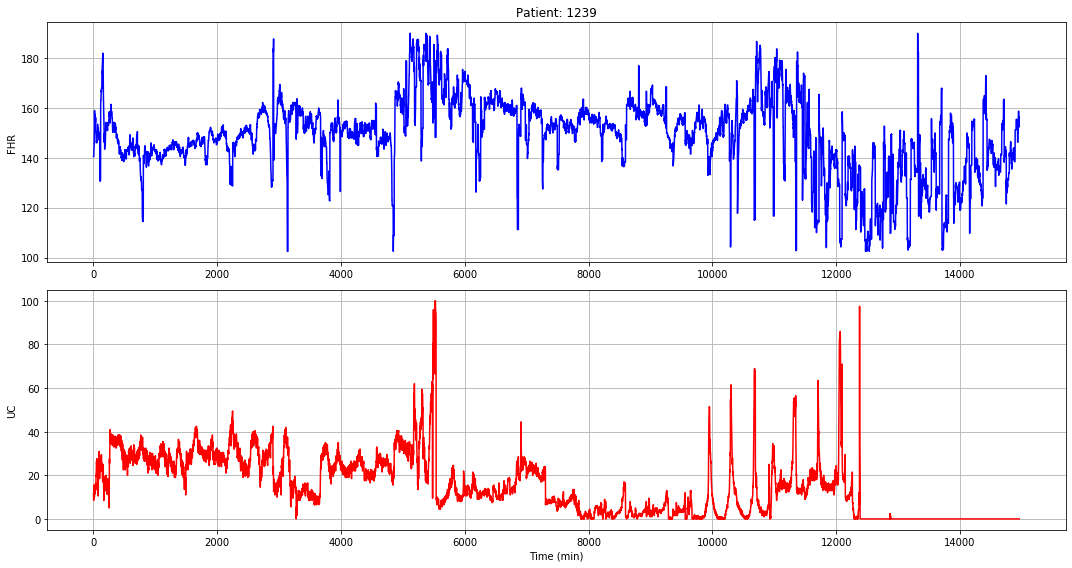

In [29]:
fhr7, uc7, time7 = drop_zeros_ctg(fhr6, uc6, time6)
fig = plot_ctg(zero_to_nan(fhr7), uc7, patient_num = patient)

In [30]:
def get_baseline(signal: np.array, time: np.array) -> Dict[str, float]:
    """
    Calculate baseline of the signal 
    fitted as bo + b1*t

    Args:
        signal: (np.array) 1D FHR signal
        time: (np.array) 1D time array

    Output: (Tuple) b0 and b1 from baseline fit
    """     
    if len(signal[signal==0]) > 0: raise ValueError('Takes preprocessed signals without zeros')
    if len(signal) != len(time): raise ValueError('Signal and time must have the same lengths')
    feature_dict = dict()    
    
    [b1, b0] = np.polyfit(time, signal, 1)
    feature_dict['baseline'] = b0
    feature_dict['slope'] = b1
    
    return feature_dict

In [31]:
feature_dict = get_baseline(fhr7, time7)

In [32]:
feature_dict

{'baseline': 155.90331848497686, 'slope': -0.0007374770807383017}

In [33]:
def test_regression(signal: np.array, time: np.array):
    #signal = np.random.rand(100)+200
    #time = np.arange(len(signal))
    feature_dict = get_baseline(signal, time)
    b0 = feature_dict['baseline']
    b1 = feature_dict['slope']
    fit = b0+b1*time
    
    fig = plt.figure(figsize=(9, 5))    
    plt.plot(time, signal, 'b')
    plt.plot(time, fit, '--r')
    plt.grid(True)
    plt.tight_layout()
    plt.show()  

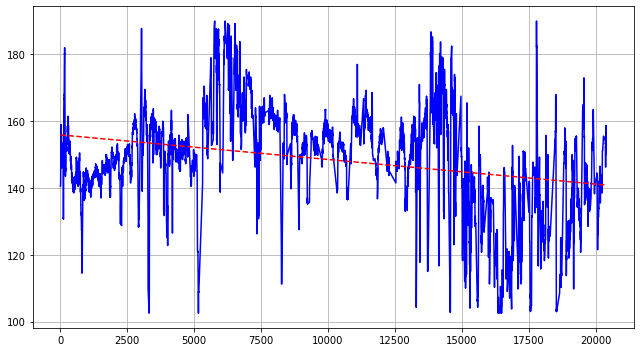

In [120]:
test_regression(fhr7, time7)

In [121]:
def get_regression(signal: np.array, time: np.array) -> dict:
    """
    Calculate baseline of the signal 
    fitted as bo + b1*t

    Args:
        signal: (np.array) 1D FHR signal
        time: (np.array) 1D time array

    Output: (dict) coef and RMS error from baseline fit
    """ 
    feature_dict = dict()  

    model = LinearRegression().fit(time.reshape(-1, 1), signal.reshape(-1, 1))    
    r2_score = model.score(time.reshape(-1, 1), signal.reshape(-1, 1))
    baseline = model.intercept_
    slope = model.coef_

    #feature_dict['baseline'] = baseline
    #feature_dict['slope'] = slope
    feature_dict['r2_score'] = r2_score

    return feature_dict

In [122]:
model = LinearRegression().fit(time7.reshape(-1, 1), fhr7.reshape(-1, 1))    

In [123]:
r2_score = model.score(time7.reshape(-1, 1), fhr7.reshape(-1, 1))
r2_score

0.08779070972813219

In [124]:
model.intercept_

array([155.90331848])

In [125]:
model.coef_

array([[-0.00073748]])

In [126]:
feature_dict

{'baseline': 155.90331848497686, 'slope': -0.0007374770807383017}

In [127]:
feature_dict = get_regression(fhr7, time7)

In [128]:
feature_dict

{'r2_score': 0.08779070972813219}

In [129]:
def get_basic_stats(signal: np.array) -> Dict[str, float]:        
    """
    Calculate basic statistics of the signal     
    
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """
    sig = signal[signal != 0].copy()
    feature_dict = dict()
    
    mean = np.mean(sig)
    median = np.median(sig)
    minimum = np.min(sig)
    maximum = np.max(sig)
    mad = np.median(np.absolute(sig - np.median(sig)))
    mean_abs_deviation = np.mean(np.absolute(sig - np.mean(sig)))
    std = np.std(sig)
    average_change = np.mean(np.diff(sig))
    
    feature_dict={
        'mean': mean,
        'median': median,
        'min': minimum,
        'max': maximum,
        'mad': mad,
        'mean_abs_deviation': mean_abs_deviation,
        'std': std,
        'var': np.var(sig),
        'ptp': np.ptp(sig),
        'average_change': average_change,
        }
    return feature_dict

In [130]:
get_basic_stats(fhr7)

{'mean': 148.9523395721925,
 'median': 150.5,
 'min': 102.5,
 'max': 190.0,
 'mad': 7.75,
 'mean_abs_deviation': 11.092814126440564,
 'std': 14.919899248673667,
 'var': 222.6033935905731,
 'ptp': 87.5,
 'average_change': 0.0008021926599371615}

In [131]:
def get_change_rate(signal: np.array) -> float:
    """
    Get change rate of the signal     
        
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """
    feature_dict = dict()
    x = signal[signal != 0]

    change = (np.diff(x) / x[:-1])
    change = change[np.nonzero(change)[0]]
    change = change[~np.isnan(change)]
    change = change[change != -np.inf]
    change = change[change != np.inf]
    feature_dict['change_rate'] = np.mean(change)

    return feature_dict

In [132]:
get_change_rate(fhr7)

{'change_rate': 0.00047273334540463396}

In [133]:
def get_percentiles(signal: np.array) -> Dict[str, float]:        
    """
    Calculate percentiles from the signal     
    
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """
    x = signal[signal != 0].copy()
    feature_dict = dict()
    
    feature_dict['percentile_10'] = np.percentile(x, 10)
    feature_dict['percentile_20'] = np.percentile(x, 20)
    feature_dict['percentile_30'] = np.percentile(x, 30)
    feature_dict['percentile_40'] = np.percentile(x, 40)
    feature_dict['percentile_50'] = np.percentile(x, 50)
    feature_dict['percentile_60'] = np.percentile(x, 60)
    feature_dict['percentile_70'] = np.percentile(x, 70)
    feature_dict['percentile_80'] = np.percentile(x, 80)
    feature_dict['percentile_90'] = np.percentile(x, 90)
    
    return feature_dict

In [134]:
get_percentiles(fhr7)

{'percentile_10': 128.5,
 'percentile_20': 139.5,
 'percentile_30': 144.0,
 'percentile_40': 147.5,
 'percentile_50': 150.5,
 'percentile_60': 153.25,
 'percentile_70': 156.25,
 'percentile_80': 159.5,
 'percentile_90': 164.25}

In [135]:
def get_scipy_stats(signal: np.array) -> Dict[str, float]:
    """
    Calculate basic scypy stats from the signal     
    
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """
    x = signal[signal != 0]
    feature_dict = dict()
    
    feature_dict['skew'] = stats.skew(x)
    feature_dict['kurtosis'] = stats.kurtosis(x)

    # k-statistic and moments
    feature_dict['kstat_1'] = stats.kstat(x, 1)
    feature_dict['kstat_2'] = stats.kstat(x, 2)
    feature_dict['kstat_3'] = stats.kstat(x, 3)
    feature_dict['kstat_4'] = stats.kstat(x, 4)
    feature_dict['moment_1'] = stats.moment(x, 1)
    feature_dict['moment_2'] = stats.moment(x, 2)
    feature_dict['moment_3'] = stats.moment(x, 3)
    feature_dict['moment_4'] = stats.moment(x, 4)

    return feature_dict

In [136]:
get_scipy_stats(fhr7)

{'skew': -0.5458826034655794,
 'kurtosis': 0.8823645964642854,
 'kstat_1': 148.9523395721925,
 'kstat_2': 222.61827449127438,
 'kstat_3': -1813.3599575668677,
 'kstat_4': 43763.516099569606,
 'moment_1': 0.0,
 'moment_2': 222.6033935905731,
 'moment_3': -1812.996332070084,
 'moment_4': 192379.9819760146}

In [137]:
def get_peak_features(signal: np.array, time: np.array, distance: int = 200) -> Dict[str, float]:
    """
    Find peaks inside a 1-D array. 
    Calculate the prominence of each peak in a signal.
    The prominence of a peak measures how much a peak stands out from the surrounding baseline; 
    defined as the vertical distance between the peak and its lowest contour line.    
    
    Args:
        signal: (np.array) 1D signal
        time: (np.array) 1D time array
        distance: (int) minimal horizontal distance in samples between neighbouring peaks. 
                    Smaller peaks are removed first until the condition is fulfilled for all remaining peaks.

    Output: (Dict) of peak  statistics from the signal
    """
    x = signal[signal != 0]
    feature_dict = dict()
    
    peaks, properties = find_peaks(x, distance=distance, height=x.mean(), width=20, rel_height=0.5)
    widths_half = peak_widths(x, peaks, rel_height=0.5)
    print(peaks)
    #print(widths_half)
    widths_full = peak_widths(x, peaks, rel_height=1)
    prominences, left_bases, right_bases = peak_prominences(x, peaks)  
    
    feature_dict['num_peaks'] = len(peaks)
    feature_dict['peaks_distance'] = np.mean(np.diff(peaks))
    feature_dict['mean_peak_halfwidth'] = np.mean(widths_half)
    feature_dict['mean_peak_fullwidth'] = np.mean(widths_full)
    feature_dict['mean_peak_prominence'] = np.mean(prominences)
    
    return feature_dict

In [138]:
get_peak_features(fhr7, time7)

[  151  1687  1891  2096  3285  3638  3951  4231  4558  4878  5115  5372
  5720  5963  6493  6914  7340  7550  7911  8171  8809  9031  9551  9784
 10149 10392 10715 11038 11375 11723 12096 12779 13033 13705 14419 14711]


{'num_peaks': 36,
 'peaks_distance': 416.0,
 'mean_peak_halfwidth': 3983.8381484670576,
 'mean_peak_fullwidth': 4281.3054585476875,
 'mean_peak_prominence': 38.166666666666664}

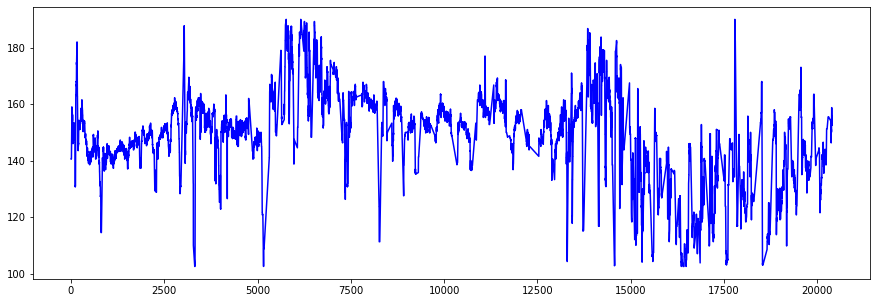

In [139]:
fig = plt.figure(figsize=(15, 5))    
plt.plot(time7, fhr7, 'b')

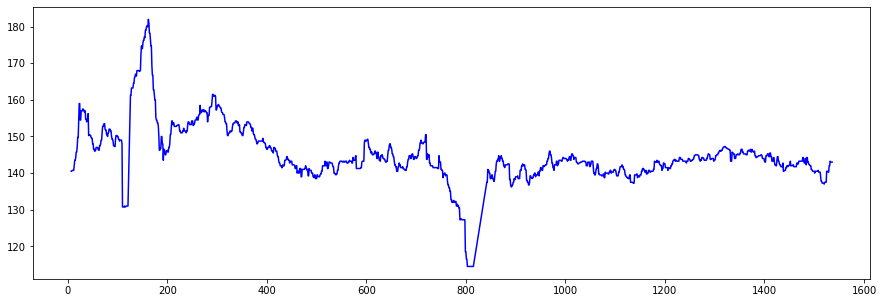

In [140]:
fig = plt.figure(figsize=(15, 5))    
plt.plot(time7[:1500], fhr7[:1500], 'b')

In [36]:
def test_peaks(x):

    peaks, properties = find_peaks(x, distance=100, prominence = 15, height=x.mean(), width=20, rel_height=0.5)
    prominences = peak_prominences(x, peaks)[0]  
    widths_half = peak_widths(x, peaks, rel_height=0.5)
    contour_heights = x[peaks] - prominences
    plt.figure(figsize=(15, 5))  
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    #plt.vlines(x=peaks, ymin=contour_heights, ymax=x[peaks], color = "C1")
    #plt.hlines(y=widths_half, xmin=properties["left_ips"],
    #           xmax=properties["right_ips"], color = "C1")
    plt.show()

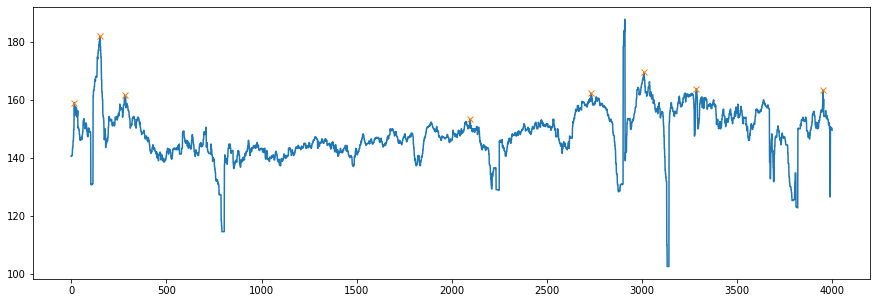

In [38]:
test_peaks(fhr7[:4000])

In [143]:
def compute_hjoth(signal: np.array) -> Dict[str, float]:
    """
    Calculate basic scypy stats from the signal     
    
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """    
    feature_dict = dict()

    activity = np.var(signal)
    sig_diff = np.diff(signal)    
    mobility = np.sqrt(np.var(sig_diff) / activity)
    mobility_diff = np.sqrt(np.var(np.diff(sig_diff)) / np.var(sig_diff))
    complexity = mobility_diff / mobility

    feature_dict['mobility'] = mobility
    feature_dict['complexity'] = complexity

    return feature_dict

In [144]:
compute_hjoth(fhr7)

{'mobility': 0.190179884194941, 'complexity': 7.43163660144949}

In [145]:
def get_wavelet_features(signal: np.array, wavelet: str = "db4") -> Dict[str, float]:
    """
    Get wavelet transform features
        
    Args:
        signal: (np.array) 1D signal
        wavelet: (str) wavelet type
        
    Output: (Dict) of decelerations statistics from the signal
    """

    feature_dict = dict()
    # calculate the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, mode="per")    
    for i, coeff in enumerate(coeffs):
        coeff_energy = (coeff ** 2)
        feature_dict[f'wavelet_square_{i}_mean'] = np.mean(coeff_energy)
        feature_dict[f'wavelet_square_{i}_max'] = np.max(coeff_energy)
        feature_dict[f'wavelet_square_{i}_sum'] = np.sum(coeff_energy) 
        feature_dict[f'wavelet_square_{i}_var'] = np.sqrt(np.var(coeff_energy))
        
    return feature_dict

In [65]:
get_wavelet_features(fhr7)

{'wavelet_square_0_mean': 44745297.25692544,
 'wavelet_square_0_max': 52470859.44897639,
 'wavelet_square_0_sum': 357962378.05540353,
 'wavelet_square_0_var': 6306673.455011363,
 'wavelet_square_1_mean': 33742.0671268029,
 'wavelet_square_1_max': 121061.66913247592,
 'wavelet_square_1_sum': 269936.5370144232,
 'wavelet_square_1_var': 36477.70608527758,
 'wavelet_square_2_mean': 14841.178859411653,
 'wavelet_square_2_max': 40866.21340065962,
 'wavelet_square_2_sum': 222617.6828911748,
 'wavelet_square_2_var': 12281.711181183484,
 'wavelet_square_3_mean': 2826.2418445187814,
 'wavelet_square_3_max': 17296.288081315524,
 'wavelet_square_3_sum': 84787.25533556344,
 'wavelet_square_3_var': 4089.9365656335726,
 'wavelet_square_4_mean': 4002.385257395408,
 'wavelet_square_4_max': 20180.233566035753,
 'wavelet_square_4_sum': 236140.73018632908,
 'wavelet_square_4_var': 4725.474026808318,
 'wavelet_square_5_mean': 2927.3136581770427,
 'wavelet_square_5_max': 24919.00051783823,
 'wavelet_square_

In [40]:
def get_tsfresh_features(signal: np.array) -> Dict[str, float]:
    """
    Calculate features from tsfresh libruary     
    
    Args:
        signal: (np.array) 1D signal        

    Output: (dict) of basic statistics from the signal
    """
    x = signal[signal != 0].copy()
    feature_dict = dict()

    feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
    feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
    feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
    feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
    feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
    feature_dict['mean_change'] = feature_calculators.mean_change(x)
    feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)        

    feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
    
    feature_dict['time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    feature_dict['time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)
    feature_dict['time_rev_asym_stat_1000'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1000)

    feature_dict['autocorrelation_5'] = feature_calculators.autocorrelation(x, 5)
    feature_dict['autocorrelation_10'] = feature_calculators.autocorrelation(x, 10)
    feature_dict['autocorrelation_50'] = feature_calculators.autocorrelation(x, 50)
    feature_dict['autocorrelation_100'] = feature_calculators.autocorrelation(x, 100)
    feature_dict['autocorrelation_1000'] = feature_calculators.autocorrelation(x, 1000)
    
    feature_dict['c3_5'] = feature_calculators.c3(x, 5)
    feature_dict['c3_10'] = feature_calculators.c3(x, 10)
    feature_dict['c3_100'] = feature_calculators.c3(x, 100)

    feature_dict['fft_1_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'real'}]))[0][1]
    feature_dict['fft_1_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'imag'}]))[0][1]
    feature_dict['fft_1_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 1, 'attr': 'angle'}]))[0][1]
    feature_dict['fft_2_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'real'}]))[0][1]
    feature_dict['fft_2_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'imag'}]))[0][1]
    feature_dict['fft_2_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 2, 'attr': 'angle'}]))[0][1]
    feature_dict['fft_3_real'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'real'}]))[0][1]
    feature_dict['fft_3_imag'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'imag'}]))[0][1]
    feature_dict['fft_3_ang'] = list(feature_calculators.fft_coefficient(x, [{'coeff': 3, 'attr': 'angle'}]))[0][1]

    feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
    feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
    feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
    feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

    feature_dict['binned_entropy_5'] = feature_calculators.binned_entropy(x, 5)
    feature_dict['binned_entropy_10'] = feature_calculators.binned_entropy(x, 10)
    feature_dict['binned_entropy_20'] = feature_calculators.binned_entropy(x, 20)
    feature_dict['binned_entropy_50'] = feature_calculators.binned_entropy(x, 50)
    feature_dict['binned_entropy_80'] = feature_calculators.binned_entropy(x, 80)
    feature_dict['binned_entropy_100'] = feature_calculators.binned_entropy(x, 100)

    feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)
    feature_dict['num_peaks_10'] = feature_calculators.number_peaks(x, 10)
    feature_dict['num_peaks_50'] = feature_calculators.number_peaks(x, 50)
    feature_dict['num_peaks_100'] = feature_calculators.number_peaks(x, 100)
    feature_dict['num_peaks_500'] = feature_calculators.number_peaks(x, 500)

    feature_dict['spkt_welch_density_1'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 1}]))[0][1]
    feature_dict['spkt_welch_density_10'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 10}]))[0][1]
    feature_dict['spkt_welch_density_50'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 50}]))[0][1]
    feature_dict['spkt_welch_density_100'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': 100}]))[0][1]

    feature_dict['time_rev_asym_stat_1'] = feature_calculators.time_reversal_asymmetry_statistic(x, 1)
    feature_dict['time_rev_asym_stat_10'] = feature_calculators.time_reversal_asymmetry_statistic(x, 10)
    feature_dict['time_rev_asym_stat_100'] = feature_calculators.time_reversal_asymmetry_statistic(x, 100)        

    return feature_dict

ModuleNotFoundError: No module named 'tsfresh'